In [2]:
# pip install seaborn
# pip install statsmodels

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import ttest_ind, mannwhitneyu

In [129]:
df = pd.read_csv('train.csv', encoding='ISO-8859-1')
df.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_desc_length,inquiry_type,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,NaN,purchasing,62,Quotation or purchase consultation,multi-split,NaN,NaN,/Quezon City/Philippines,entry level,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,NaN,media and communication,96,Quotation or purchase consultation,multi-split,NaN,NaN,/PH-00/Philippines,ceo/founder,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,NaN,engineering,56,Product Information,single-split,NaN,NaN,/Kolkata /India,partner,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,NaN,entrepreneurship,44,Quotation or purchase consultation,vrf,NaN,NaN,/Bhubaneswar/India,ceo/founder,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,NaN,consulting,97,Quotation or purchase consultation,multi-split,NaN,NaN,/Hyderabad/India,partner,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  product_category      

In [131]:
df.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_country.1', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area',
       'business_subarea', 'lead_owner', 'is_converted'],
      dtype='object')

In [132]:
df.describe()

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,lead_desc_length,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,lead_owner
count,59299.000000,14568.000000,59299.000000,13756.000000,3444.0,1121.0,4565.0,59299.000000,59299.000000,59299.000000,18417.000000,15304.000000,59299.000000
mean,0.634593,0.091685,27114.556333,19.912184,1.0,1.0,1.0,79.271590,0.041603,0.050810,0.001117,0.049288,262.563888
std,0.286066,0.150988,14653.911888,44.697938,0.0,0.0,0.0,132.551067,0.199681,0.219612,0.001104,0.027949,231.605681
min,0.000000,0.003788,2.000000,0.000000,1.0,1.0,1.0,1.000000,0.000000,0.000000,0.000002,0.011583,0.000000
25%,0.500000,0.019900,14913.000000,1.000000,1.0,1.0,1.0,7.000000,0.000000,0.000000,0.000298,0.026846,97.000000
50%,0.500000,0.049180,26774.000000,4.000000,1.0,1.0,1.0,29.000000,0.000000,0.000000,0.000572,0.049840,175.000000
75%,1.000000,0.074949,40368.500000,19.000000,1.0,1.0,1.0,92.000000,0.000000,0.000000,0.001183,0.064566,374.000000
max,1.000000,1.000000,47466.000000,1394.000000,1.0,1.0,1.0,1264.000000,1.000000,1.000000,0.003079,0.285714,1114.000000


## is_converted 칼럼 정리

In [133]:
#1. is_converted가 NA인 데이터 drop
df = df.dropna(subset=['is_converted'])
erased_rows = 59300-len(df)
print('지워진 행: '+str(erased_rows))

지워진 행: 1


In [134]:
print('is_converted unique values:')
df.is_converted.unique()

is_converted unique values:


array([ True, False])

In [135]:
# is_converted 의 값들 정리
# 모두 TRUE or FALSE로 통일, 이외값을 가진 행은 제거
df['is_converted'] = df['is_converted'].astype(str).str.upper()
df = df[df['is_converted'].isin(['TRUE', 'FALSE'])]
print('지워진 행: '+ str(59300-erased_rows-len(df)))

지워진 행: 0


## 칼럼별 NA율 데이타 분석

In [136]:
#칼럼별 NA율 정리
# df.isnull().sum()/len(df)*100

In [137]:
#칼럼별 NA율이 50% 이상인 칼럼 나열
for col in df.columns:
    if df[col].isnull().sum()/len(df)*100 > 50:
        print(col, df[col].isnull().sum()/len(df)*100)
        #df.drop(col, axis=1, inplace=True)

com_reg_ver_win_rate 75.43297526096562
customer_type 74.13447107033846
historical_existing_cnt 76.80230695289971
id_strategic_ver 94.19214489283124
it_strategic_ver 98.1095802627363
idit_strategic_ver 92.30172515556755
product_subcategory 84.42638155786776
product_modelname 84.43649977234018
expected_timeline 52.04640887704684
ver_win_rate_x 68.94214067690855
ver_win_ratio_per_bu 74.19180761901549
business_area 68.94214067690855
business_subarea 90.6811244709017


In [138]:
#칼럼별 NA율이 90% 이상인 칼럼 제외
# drop columns with more than 90% missing values
dropped_columns = []
for col in df.columns:
    if df[col].isnull().sum()/len(df)*100 > 90:
        df.drop(col, axis=1, inplace=True)
        
print('number of columns left: '+str(len(df.columns)))

number of columns left: 25


## 중복 행 처리

In [139]:
#3.1.중복 행 확인 
df[df.duplicated(keep='first')]

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,lead_desc_length,inquiry_type,product_category,product_subcategory,product_modelname,customer_country.1,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,lead_owner,is_converted
320,1.00,/East London/South Africa,AS,0.040816,30958,End-Customer,SMB,NaN,business development,302,Quotation or purchase consultation,etc.,NaN,NaN,/East London/South Africa,manager,LGESA,more than a year,1,0,0.003079,0.026846,corporate / office,26,FALSE
322,1.00,/East London/South Africa,AS,0.040816,30958,End Customer,SMB,NaN,business development,302,Quotation or Purchase Consultation,etc.,NaN,NaN,/East London/South Africa,manager,LGESA,more than a year,1,0,0.003079,0.026846,corporate / office,26,FALSE
344,1.00,/Medellin /Colombia,AS,0.003937,39065,NaN,SMB,0.0,engineering,7,Usage or Technical Consultation,vrf,NaN,NaN,/Medellin /Colombia,associate/analyst,LGECB,9 months ~ 1 year,0,0,0.003079,0.026846,corporate / office,41,FALSE
1253,1.00,/Brisbane/Australia,ID,0.084337,14526,NaN,Enterprise,NaN,information technology,35,Quotation or Purchase Consultation,standard signage,NaN,NaN,/Brisbane/Australia,associate/analyst,LGEAP,less than 3 months,0,1,0.003079,0.064566,corporate / office,306,FALSE
1314,1.00,//Ghana,ID,0.075000,4705,Specifier / Influencer,SMB,NaN,entrepreneurship,48,Quotation or Purchase Consultation,interactive signage,TR3DJ Series,75TR3DJ,//Ghana,ceo/founder,LGEAF,less than 3 months,0,1,0.003079,0.064566,corporate / office,170,FALSE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59134,0.75,//Mexico,ID,0.042254,33676,NaN,SMB,NaN,sales,88,Quotation or Purchase Consultation,NaN,NaN,NaN,//Mexico,none,LGEMS,less than 3 months,0,0,0.000026,0.031579,public facility,214,TRUE
59262,1.00,/rio de janeiro /Brazil,AS,0.040000,13618,Specifier/ Influencer,Enterprise,NaN,operations,93,Trainings,vrf,NaN,NaN,/rio de janeiro /Brazil,ceo/founder,LGESP,more than a year,0,0,0.000026,0.028777,public facility,97,FALSE
59275,1.00,/Temuco/Chile,AS,0.040000,22100,Specifier/ Influencer,Enterprise,0.0,administrative,3,Quotation or Purchase Consultation,control,NaN,NaN,/Temuco/Chile,manager,LGECL,less than 3 months,0,0,0.000026,0.028777,public facility,100,FALSE
59290,0.75,/DolnoÅlÄ skie/Poland,AS,NaN,6739,Specifier/ Influencer,SMB,NaN,engineering,226,Quotation or Purchase Consultation,single-split,NaN,NaN,/DolnoÅlÄ skie/Poland,entry level,LGEPL,less than 3 months,0,0,0.000026,0.028777,public facility,694,FALSE


In [140]:
# 3.2. 중복 행 제거
df.drop_duplicates(keep='first', inplace=True)
len(df)

55779

## NA율이 높은 칼럼들 처리

In [141]:
 #4. NA율이 높은 칼럼의 True/False 비율 보기
for col in df.columns:
    if df[col].isnull().sum()/len(df)*100 > 50:
        print(df[col].value_counts(dropna=False, normalize=True))


com_reg_ver_win_rate
NaN         0.746966
0.074949    0.020187
0.073248    0.014020
0.003937    0.013769
0.003788    0.012496
              ...   
0.363636    0.000233
0.444444    0.000215
0.400000    0.000215
1.000000    0.000161
0.200000    0.000090
Name: proportion, Length: 81, dtype: float64
customer_type
NaN                             0.741444
End-Customer                    0.117464
End Customer                    0.063572
Specifier/ Influencer           0.041736
Channel Partner                 0.022984
Service Partner                 0.005665
Solution Eco-Partner            0.002295
Installer/Contractor            0.000753
Specifier / Influencer          0.000681
Corporate                       0.000502
Engineer                        0.000323
HVAC Engineer                   0.000305
Technician                      0.000287
Consultant                      0.000269
Developer                       0.000251
Other                           0.000179
Software/Solution Provider      0

### com_reg_ver_win_rate vs. is_converted
#### numerical data, float type

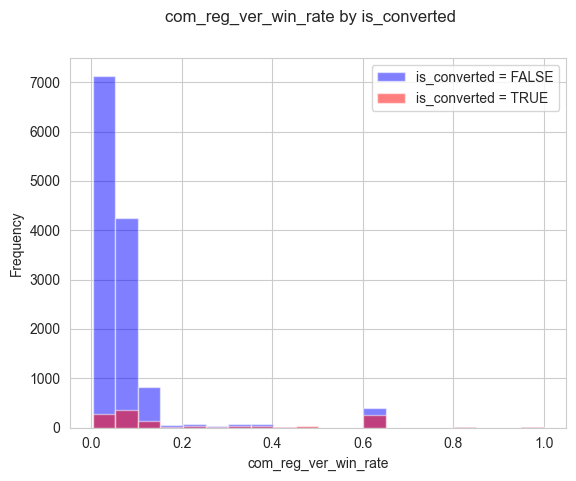

In [142]:
#com_reg_ver_win_rate 74.7%

fig, ax = plt.subplots()

ax.hist(df[df['is_converted'] == 'FALSE']['com_reg_ver_win_rate'], bins=20, alpha=0.5, color='blue', label='is_converted = FALSE')
ax.hist(df[df['is_converted'] == 'TRUE']['com_reg_ver_win_rate'], bins=20, alpha=0.5, color='red', label='is_converted = TRUE')

ax.set_xlabel('com_reg_ver_win_rate')
ax.set_ylabel('Frequency')

fig.suptitle('com_reg_ver_win_rate by is_converted')
ax.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


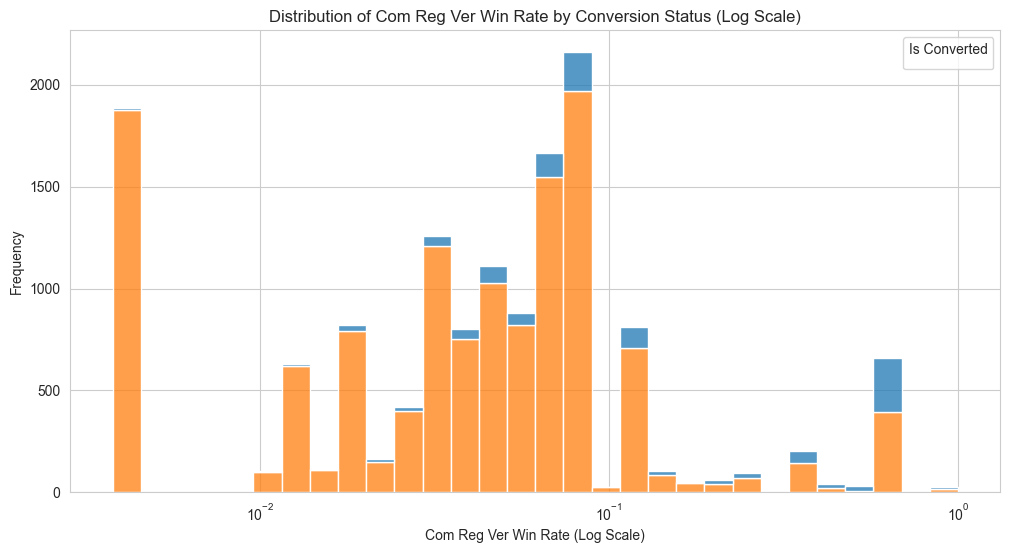

In [143]:
#logscale로 representation

plt.figure(figsize=(12, 6))
# Plotting with log scale on x-axis
sns.histplot(data=df, x='com_reg_ver_win_rate', hue='is_converted', multiple='stack', bins=30, log_scale=(True, False))
plt.title('Distribution of Com Reg Ver Win Rate by Conversion Status (Log Scale)')
plt.xlabel('Com Reg Ver Win Rate (Log Scale)')
plt.ylabel('Frequency')
plt.legend(title='Is Converted')
plt.show()

In [144]:
# 상당히 significant한 패턴 발견, t-test로 확인
# 한 그룹의 mean과 다른 그룹의 mean이 차이가 있는지 확인
# Gaussian distribution을 따르는 데이터에 대해서만 사용 가능

df['com_reg_ver_win_rate'] = pd.to_numeric(df['com_reg_ver_win_rate'], errors='coerce')

# Split the data into two groups based on is_converted value
group_true = df[df['is_converted'] == 'TRUE']['com_reg_ver_win_rate'].dropna()
group_false = df[df['is_converted'] == 'FALSE']['com_reg_ver_win_rate'].dropna()

# Run the t-test
t_stat, p_value = ttest_ind(group_true, group_false)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# T-statistic: 양수, p-value 0.05 이하 -> significant
# NA율이 높아도 is_converted에 영향을 미치는 것으로 보임, 가져가야할듯

T-statistic: 41.21953510539725, P-value: 0.0


In [145]:
# Wilcoxon test로 확인사살
# Gaussian distribution을 따르지 않는 데이터에 대해서 사용 가능
# 데이터의 rank based comparison을 수행

df['com_reg_ver_win_rate'] = pd.to_numeric(df['com_reg_ver_win_rate'], errors='coerce')

# Split the data into two groups based on is_converted value
group_true = df[df['is_converted'] == 'TRUE']['com_reg_ver_win_rate'].dropna()
group_false = df[df['is_converted'] == 'FALSE']['com_reg_ver_win_rate'].dropna()

# Run the Mann-Whitney U test
u_stat, p_value = mannwhitneyu(group_true, group_false, alternative='two-sided')

print(f"U-statistic: {u_stat}, P-value: {p_value}")

# p-value 상당히 작음 -> significant

U-statistic: 11564046.0, P-value: 1.184489223141181e-189


### customer_type vs. is_converted
#### categorical, nominal data

In [146]:
print(len(df.customer_type.unique())) # unique 한 value값 수
df.customer_type.value_counts() # value별 count

# 아래 보면, 'End-Customer' 와 'End Customer'은 같은 값이지만 오타로 다른 값처럼 사용된다.
# 둘을 하나로 합치고 작업하면 되고, 밑에 그런 예시가 더 있지만, 숫자가 상대적으로 너무 작아서 무시해도 무방하다.

34


customer_type
End-Customer                    6552
End Customer                    3546
Specifier/ Influencer           2328
Channel Partner                 1282
Service Partner                  316
Solution Eco-Partner             128
Installer/Contractor              42
Specifier / Influencer            38
Corporate                         28
Engineer                          18
HVAC Engineer                     17
Technician                        16
Consultant                        15
Developer                         14
Other                             10
Software/Solution Provider         7
End-user                           7
Manager / Director                 7
Home Owner                         6
Etc.                               6
Architect/Consultant               5
Homeowner                          5
Installer                          5
Interior Designer                  5
Distributor                        4
Others                             4
Reseller                

In [147]:
# Replace 'End Customer' with 'End-Customer' in 'customer_type' column
df['customer_type'] = df['customer_type'].replace('End Customer', 'End-Customer')

# Optionally, check the updated value counts to confirm the change
updated_counts = df['customer_type'].value_counts()

print(updated_counts)

# End-Customer 로 병합 완료. 이제 analysis 시작. 

customer_type
End-Customer                    10098
Specifier/ Influencer            2328
Channel Partner                  1282
Service Partner                   316
Solution Eco-Partner              128
Installer/Contractor               42
Specifier / Influencer             38
Corporate                          28
Engineer                           18
HVAC Engineer                      17
Technician                         16
Consultant                         15
Developer                          14
Other                              10
Software/Solution Provider          7
End-user                            7
Manager / Director                  7
Etc.                                6
Home Owner                          6
Architect/Consultant                5
Homeowner                           5
Installer                           5
Interior Designer                   5
Distributor                         4
Others                              4
Reseller                            

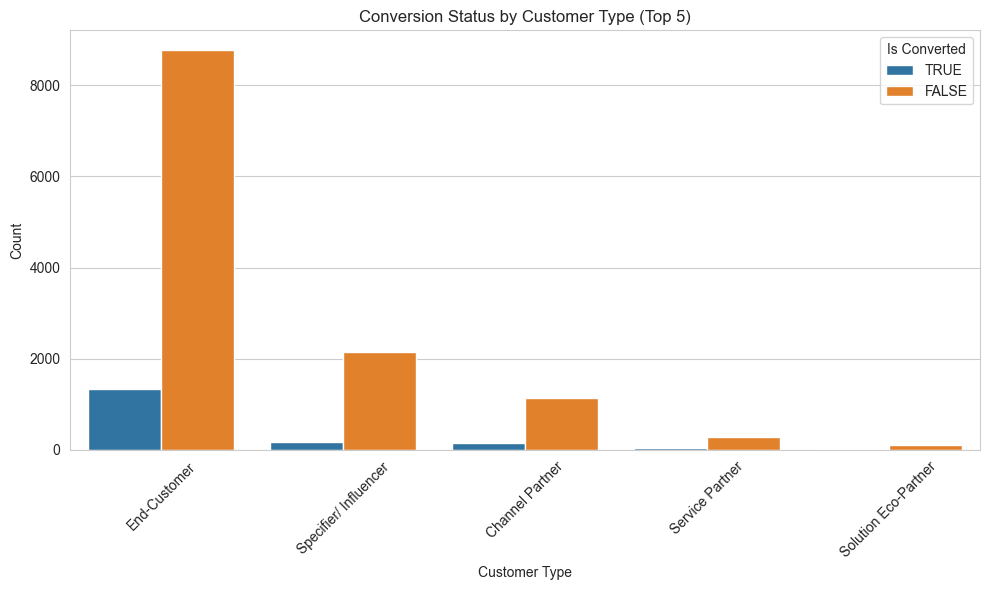

In [148]:
# visual analysis

# Find the top 5 most common values in 'customer_type'
top_5_customer_types = df['customer_type'].value_counts().nlargest(5).index

# Filter the DataFrame to keep only rows with the top 5 'customer_type' values
df_top_5_customer_types = df[df['customer_type'].isin(top_5_customer_types)]

# Create a count plot for the filtered DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_5_customer_types, x='customer_type', hue='is_converted', 
              order=df_top_5_customer_types['customer_type'].value_counts().index)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('Customer Type')
plt.ylabel('Count')
plt.title('Conversion Status by Customer Type (Top 5)')
plt.legend(title='Is Converted', loc='upper right')

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

#이렇게만 보면 또 헷갈리니, odds_ratio로 확인한다. 

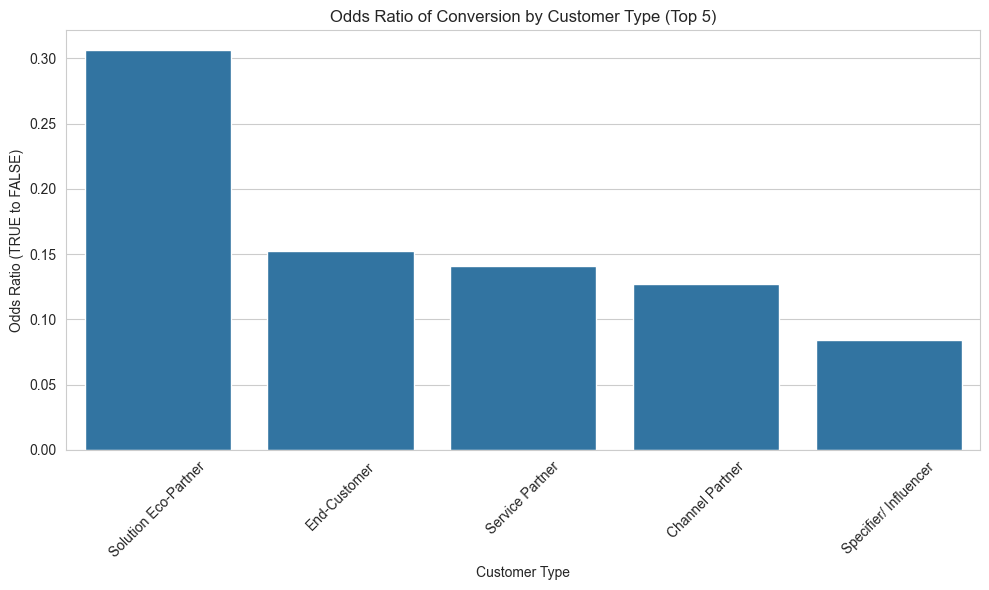

In [149]:
# Assuming df_top_5_customer_types contains only the top 5 'customer_type' categories
conversion_counts = df_top_5_customer_types.groupby('customer_type')['is_converted'].value_counts().unstack(fill_value=0)

# Calculate the odds ratio ('TRUE' to 'FALSE') for each 'customer_type'
conversion_counts['odds_ratio'] = conversion_counts['TRUE'] / conversion_counts['FALSE']

# Reset the index to make 'customer_type' a column again for plotting
conversion_counts.reset_index(inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=conversion_counts, x='customer_type', y='odds_ratio', order=conversion_counts.sort_values('odds_ratio', ascending=False)['customer_type'])

plt.xticks(rotation=45)
plt.xlabel('Customer Type')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Customer Type (Top 5)')

plt.tight_layout()
plt.show()

In [150]:
# Solution Eco-Partner가 상당히 높은것은 알겠으나, confidence가 없는것은, sample수가 워낙 적어서이다.

### historical_existing_cnt vs. is_converted
#### numerical data, int type

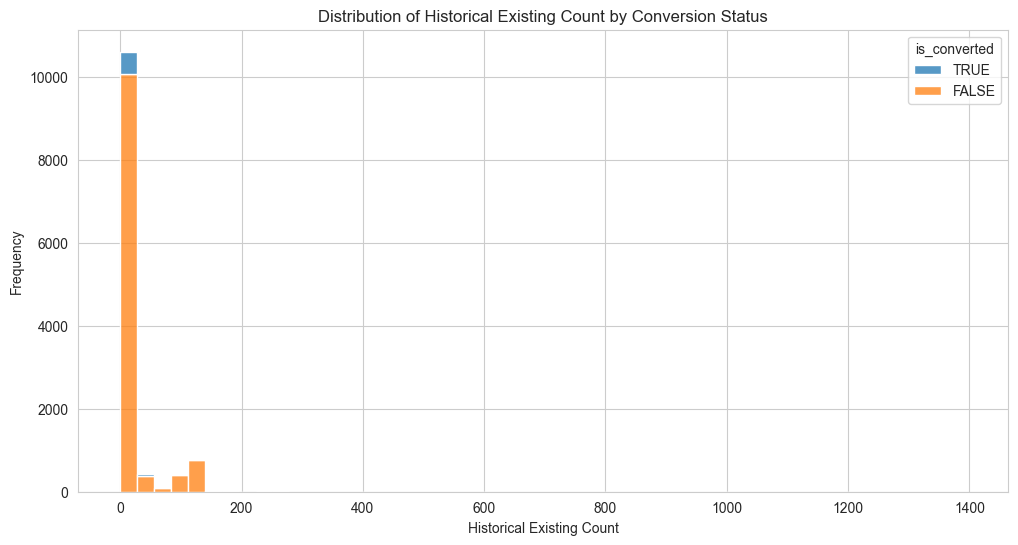

In [151]:
#historical_existing_cnt (77.7%)

# Histograms
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='historical_existing_cnt', hue='is_converted', multiple='stack', bins=50, kde=False)
plt.title('Distribution of Historical Existing Count by Conversion Status')
plt.xlabel('Historical Existing Count')
plt.ylabel('Frequency')
plt.show()

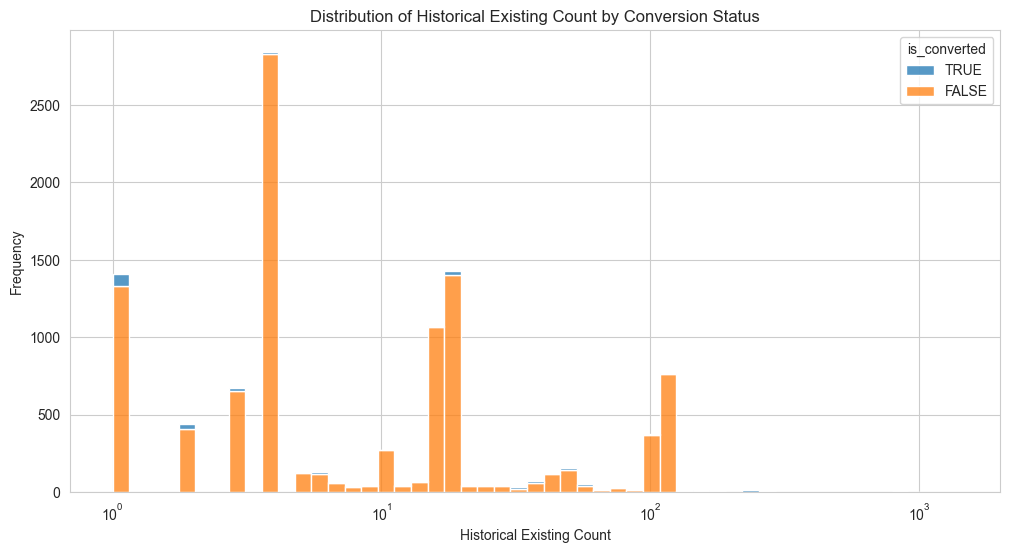

In [152]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='historical_existing_cnt', hue='is_converted', multiple='stack', log_scale=True)  # Log scale
plt.title('Distribution of Historical Existing Count by Conversion Status')
plt.xlabel('Historical Existing Count')
plt.ylabel('Frequency')
plt.show()

#뭔가 historical existing count가 높을수록, 다시 우리와의 계약이 체결될 확률이 높을 줄 알았지만,
#아래에서 보듯이 아무런 연관성이 없어보인다.

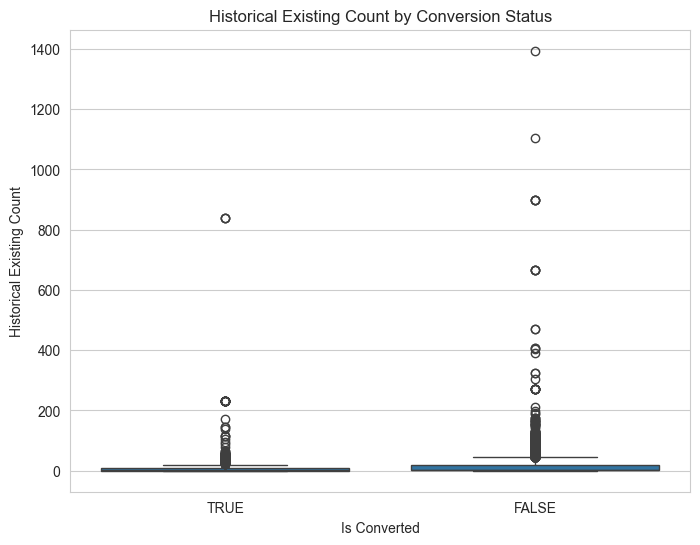

In [153]:
#historical_existing_cnt (77.7%)

# Boxplots
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_converted', y='historical_existing_cnt', data=df)
plt.title('Historical Existing Count by Conversion Status')
plt.xlabel('Is Converted')
plt.ylabel('Historical Existing Count')
plt.show()

#boxplot으로 봐도 뚜렷한 차이가 없어보인다.

In [154]:
# Split the data into two groups
group_true = df[df['is_converted'] == 'TRUE']['historical_existing_cnt']
group_false = df[df['is_converted'] == 'FALSE']['historical_existing_cnt']

# Perform the Mann-Whitney U Test
stat, p_value = mannwhitneyu(group_true, group_false)

print(f'Mann-Whitney U statistic: {stat}, P-value: {p_value}')

Mann-Whitney U statistic: nan, P-value: nan


### product_subcategory vs. is_converted
#### categorical, nominal data

In [155]:
print(len(df.product_subcategory.unique())) # unique 한 value값 수
df.product_subcategory.value_counts() # value별 count

# product model name 과 동일한 방법으로 봐야하는 칼럼. 
# 애초에 subcategory를 아시는 분들은 model명도 아신다고 볼 수 있는게,
# subcategory가 model명보다 더 큰 범주이기 때문이기도 하고
# 아래와 같이 증명하고자 한다. 

331


product_subcategory
All Medical Displays                440
Interactive Digital Board           413
TR3BF Series                        370
Diagnostic Monitors                 276
Transparent OLED Signage            270
                                   ... 
AIO                                   1
We dont offer T/F spoke to HA PM      1
LG One:Quick Flex (Telehealth)        1
VL5G-A Series                         1
EVR                                   1
Name: count, Length: 330, dtype: int64

In [156]:
# product_subcategory 를 답한 사용자들이 product_model_name도 답했는지 확인

# Filter rows where 'product_subcategory' is not NA
rows_with_subcategory = df.dropna(subset=['product_subcategory'])

# Of these, count how many also have 'product_modelname' not NA
rows_with_both = rows_with_subcategory.dropna(subset=['product_modelname'])

# Calculate proportions
total_rows_with_subcategory = len(rows_with_subcategory)
rows_with_both_count = len(rows_with_both)
proportion_with_both = rows_with_both_count / total_rows_with_subcategory

print(f"Total rows with 'product_subcategory' not NA: {total_rows_with_subcategory}")
print(f"Rows with both 'product_subcategory' and 'product_modelname' not NA: {rows_with_both_count}")
print(f"Proportion with both not NA: {proportion_with_both:.2f}")

# 83%의 확률로, subcategory를 답한 사용자들은 model명도 답했다. 
# 강한 상관관계가 있음을 알 수 있다. 앞으로 두 칼럼은 비슷한 전략을 적용할것.

Total rows with 'product_subcategory' not NA: 9006
Rows with both 'product_subcategory' and 'product_modelname' not NA: 7471
Proportion with both not NA: 0.83


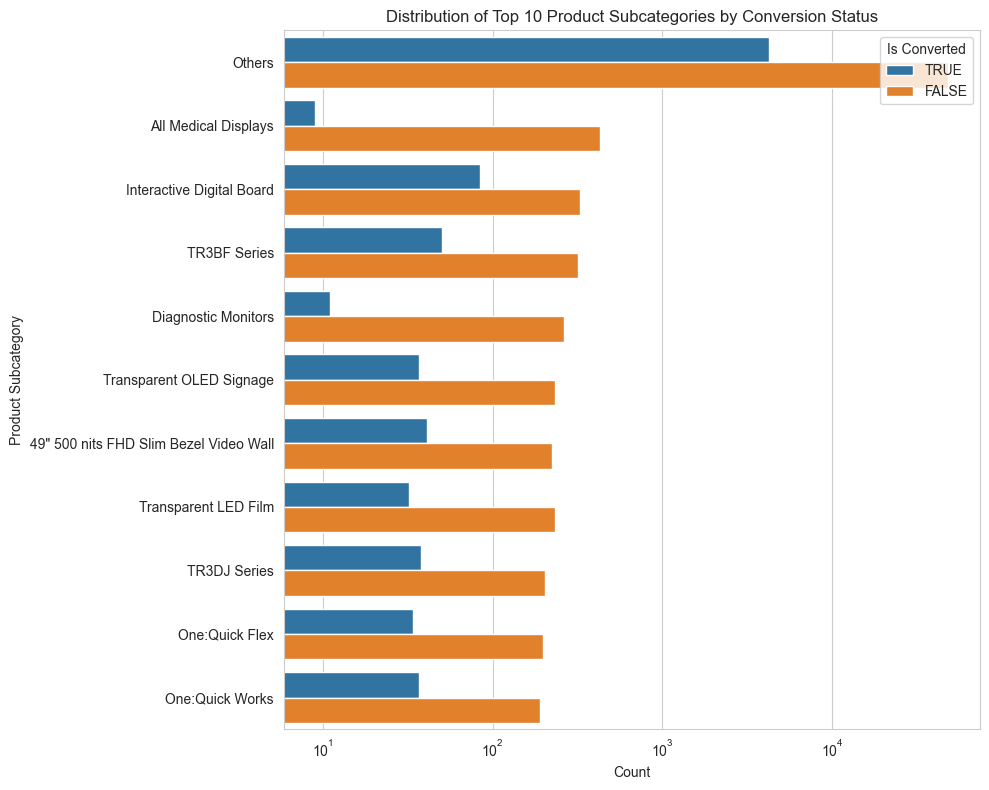

In [157]:
#product_subcategory (83.9%)
#value들이 너무 많아서, 가장 많이 반복되는 value 10개를 제외하고 나머지는 'Others'로 통합

# Focus on top 10 'product_subcategory' values
top_10_subcategories = df['product_subcategory'].value_counts().nlargest(10).index
df['product_subcategory'] = df['product_subcategory'].apply(lambda x: x if x in top_10_subcategories else 'Others')

# Plot adjustments
plt.figure(figsize=(10, 8))  # Adjust figure size
sns.countplot(data=df, y='product_subcategory', hue='is_converted', order=df['product_subcategory'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Product Subcategory')
plt.title('Distribution of Top 10 Product Subcategories by Conversion Status')
plt.legend(title='Is Converted', loc='upper right')

# Set x-axis to log scale
plt.xscale('log')

plt.tight_layout()
plt.show()

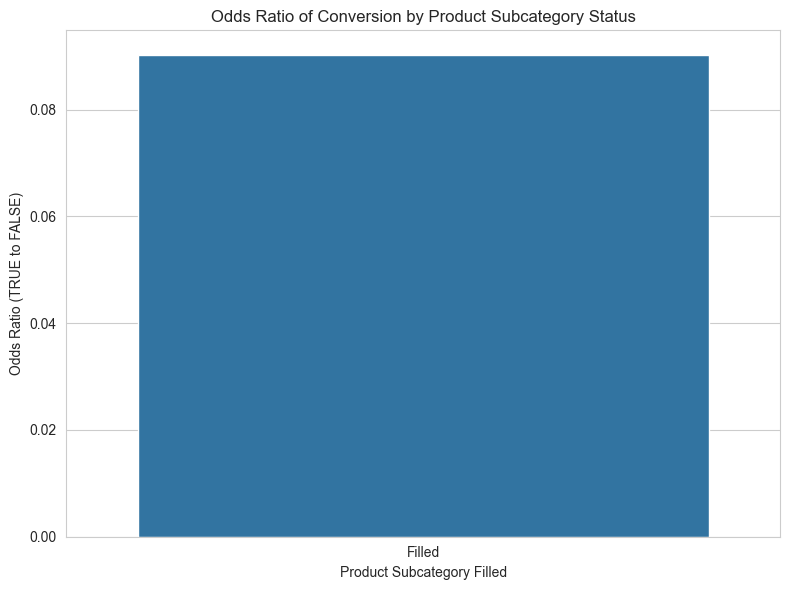

In [158]:
# product_modelname과 마찬가지로, subcategory를 기입한 사용자들이 과연 is_converted에 영향을 미치는지 확인해보자.

# Create a new column to categorize rows based on 'product_subcategory' being filled or NA
df['product_subcategory_filled'] = np.where(df['product_subcategory'].isna(), 'NA', 'Filled')

# Calculate the counts of 'is_converted' for each category
conversion_counts = df.groupby('product_subcategory_filled')['is_converted'].value_counts().unstack(fill_value=0)

# Calculate odds ratio ('TRUE' to 'FALSE') for each category
conversion_counts['odds_ratio'] = conversion_counts['TRUE'] / conversion_counts['FALSE']

# Reset index to make 'product_subcategory_filled' a column (for plotting)
conversion_counts.reset_index(inplace=True)

# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(data=conversion_counts, x='product_subcategory_filled', y='odds_ratio')
plt.xlabel('Product Subcategory Filled')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Product Subcategory Status')
plt.tight_layout()
plt.show()

# 아래서 보듯이, subcategory를 기입한 사용자들이 is_converted가 TRUE가 되는데 영향을 미치는 것으로 보인다.

### product_modelname vs. is_converted
#### categorical, nominal data

In [159]:
print(len(df.product_modelname.unique())) # unique 한 value값 수
df.product_modelname.value_counts() # value별 count

# product modelname 같은 경우는 사실 상식적으로 봤을때, product_modelname 자체를 주었느냐 안주었느냐,
# modelname을 알정도로 관심을 가졌느냐라는 정보로, one-hot encoding을 통해
# value가 있으면 1로 인코딩, value가 NA이면 0으로 인코딩하는것이 좋은지 확인하자. 

666


product_modelname
UltraFine Ergo(32UN880)    519
28MQ780                    471
All Medical Displays       348
43HT3WJ                    278
55CT5WJ                    258
                          ... 
55US660H0SD.BWZ              1
86UL3J                       1
55EJ5E-B                     1
43UT662M (MEA)               1
55US660H (SCA)               1
Name: count, Length: 665, dtype: int64

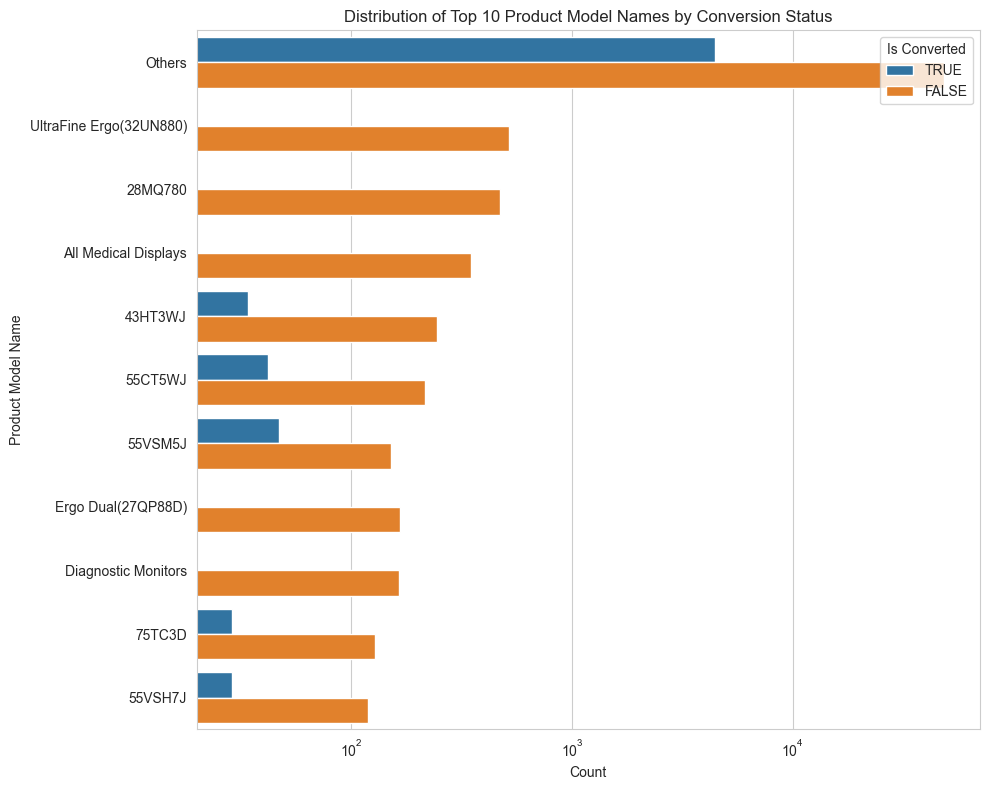

In [160]:
#product_modelname (83.9%)

# 위와 동일한 방법으로 진행

# Focus on top 10 'product_modelname' values
top_10_subcategories = df['product_modelname'].value_counts().nlargest(10).index
df['product_modelname'] = df['product_modelname'].apply(lambda x: x if x in top_10_subcategories else 'Others')

# Plot adjustments
plt.figure(figsize=(10, 8))  # Adjust figure size
sns.countplot(data=df, y='product_modelname', hue='is_converted', order=df['product_modelname'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Product Model Name')
plt.title('Distribution of Top 10 Product Model Names by Conversion Status')
plt.legend(title='Is Converted', loc='upper right')

# Set x-axis to log scale
plt.xscale('log')

plt.tight_layout()
plt.show()

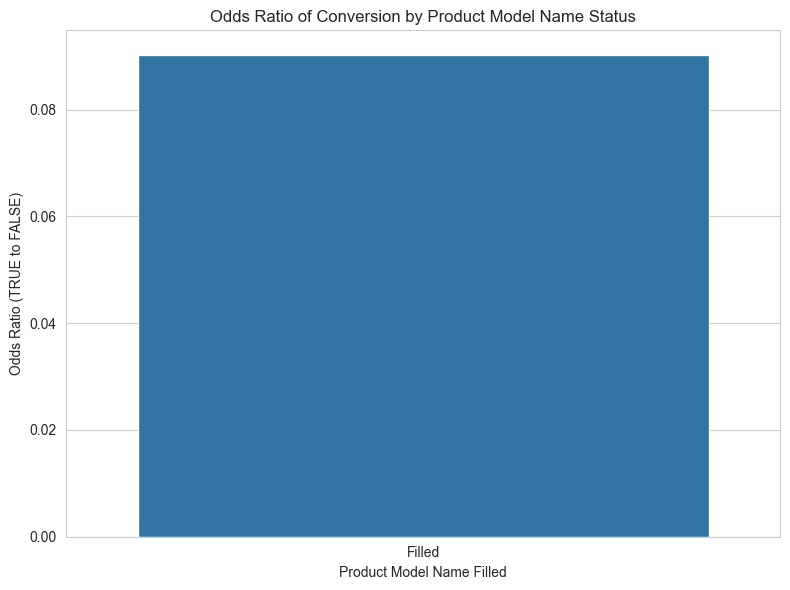

In [161]:
# 위 visualization 만으로는, 특정 modelname의 영향은 없어보인다. 우리가 진짜 알고 싶은 insight는, 
# modelname을 작성한 사용자들이 conversion에 영향을 미치는지 여부이다.

# Create a new column to categorize rows based on 'product_modelname' being filled or NA
df['product_modelname_filled'] = np.where(df['product_modelname'].isna(), 'NA', 'Filled')

# Calculate the counts of 'is_converted' for each category
conversion_counts = df.groupby('product_modelname_filled')['is_converted'].value_counts().unstack(fill_value=0)

# Calculate odds ratio ('TRUE' to 'FALSE') for each category
conversion_counts['odds_ratio'] = conversion_counts['TRUE'] / conversion_counts['FALSE']

# Reset index to make 'product_modelname_filled' a column (for plotting)
conversion_counts.reset_index(inplace=True)

# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(data=conversion_counts, x='product_modelname_filled', y='odds_ratio')
plt.xlabel('Product Model Name Filled')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Product Model Name Status')
plt.tight_layout()
plt.show()

#아래서 보듯이, modelname을 작성한 사용자들은 convert할 확률이 거의 두배에 미친다. 

### expected_timeline vs. is_converted
#### categorical, nominal data -> 정제하면 ordinal data 가능

In [162]:
print(len(df.expected_timeline.unique())) # unique 한 value값 수
df.expected_timeline.value_counts() # value별 count

#전략적으로, 상위 종목 5개가 아니면, 'Others'로 통합하거나 drop하는 것이 좋을 것으로 보임

450


expected_timeline
less than 3 months                                                                                                            16768
3 months ~ 6 months                                                                                                            4798
more than a year                                                                                                               2874
9 months ~ 1 year                                                                                                              1070
6 months ~ 9 months                                                                                                            1043
                                                                                                                              ...  
no requirement of this time                                                                                                       1
not reachable , lead shared with partner                  

In [163]:
df.expected_timeline.unique()

array(['less than 3 months', nan, '3 months ~ 6 months',
       '9 months ~ 1 year', 'more than a year', '6 months ~ 9 months',
       'quote has been sent to customer.',
       'partner was exploring on eol model for some requiremeent. no designated sales or closure expected hence closing in the system.',
       'already close in july purchse with rd',
       'client not interested in product.. receing call and not answering properly',
       'being followed up', 'being followed up.',
       'repeated inquiry from client. he was just inquiring but have not confimred on purchase. we have tried mulitple times but client is not interested in buying.',
       'update- 7th aug--demo given. customer will confirm next week',
       "tried to reach him multipe times from last 7 days but couldn't get through",
       'details send', 'discused with ankit in dehli',
       'requires detail for tender. no purchase requirement right now.',
       'partner is into static signages. he need to connec

In [164]:
# working on processing 

# Replace the specified 'expected_timeline' values
df['expected_timeline'] = df['expected_timeline'].replace({
    'less_than_3_months': 'less than 3 months',  # merge into 'less than 3 months'
    'being followed up': 'being followed up.',  # merge into 'being followed up.'
    'less than 6 months': '3 months ~ 6 months',  # merge into '3 months ~ 6 months'
    '3_months_~_6_months' : '3 months ~ 6 months'
})

# Optional: Check the updated value counts to confirm the merges
updated_counts = df['expected_timeline'].value_counts()
print(updated_counts)

expected_timeline
less than 3 months                                                                                                            16843
3 months ~ 6 months                                                                                                            4915
more than a year                                                                                                               2874
9 months ~ 1 year                                                                                                              1070
6 months ~ 9 months                                                                                                            1043
                                                                                                                              ...  
no requirement of this time                                                                                                       1
not reachable , lead shared with partner                  

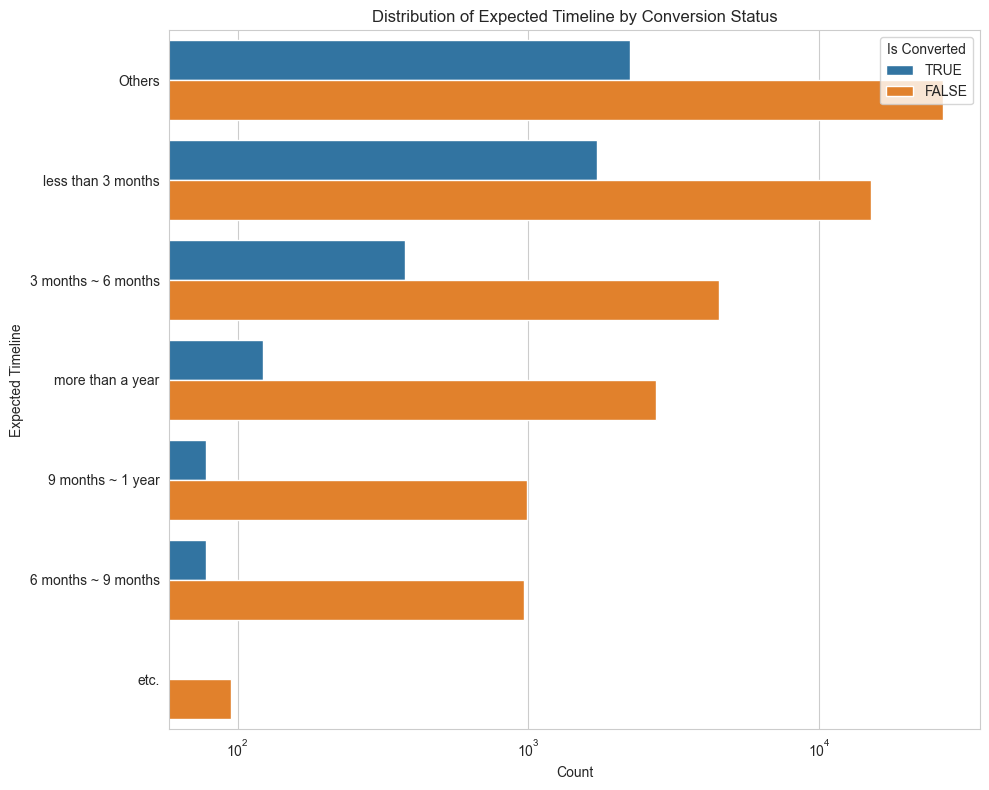

In [165]:
# expected_timeline (50.8%)

top_expected_timelines = df['expected_timeline'].value_counts().nlargest(6).index

# Replace all other 'expected_timeline' values with 'Others'
df['expected_timeline'] = df['expected_timeline'].apply(lambda x: x if x in top_expected_timelines else 'Others')

plt.figure(figsize=(10, 8))  # Adjust figure size for readability
sns.countplot(data=df, y='expected_timeline', hue='is_converted', order=df['expected_timeline'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Expected Timeline')
plt.title('Distribution of Expected Timeline by Conversion Status')
plt.legend(title='Is Converted', loc='upper right')

# If applying a semilog scale is meaningful for the counts
plt.xscale('log')

plt.tight_layout()
plt.show()

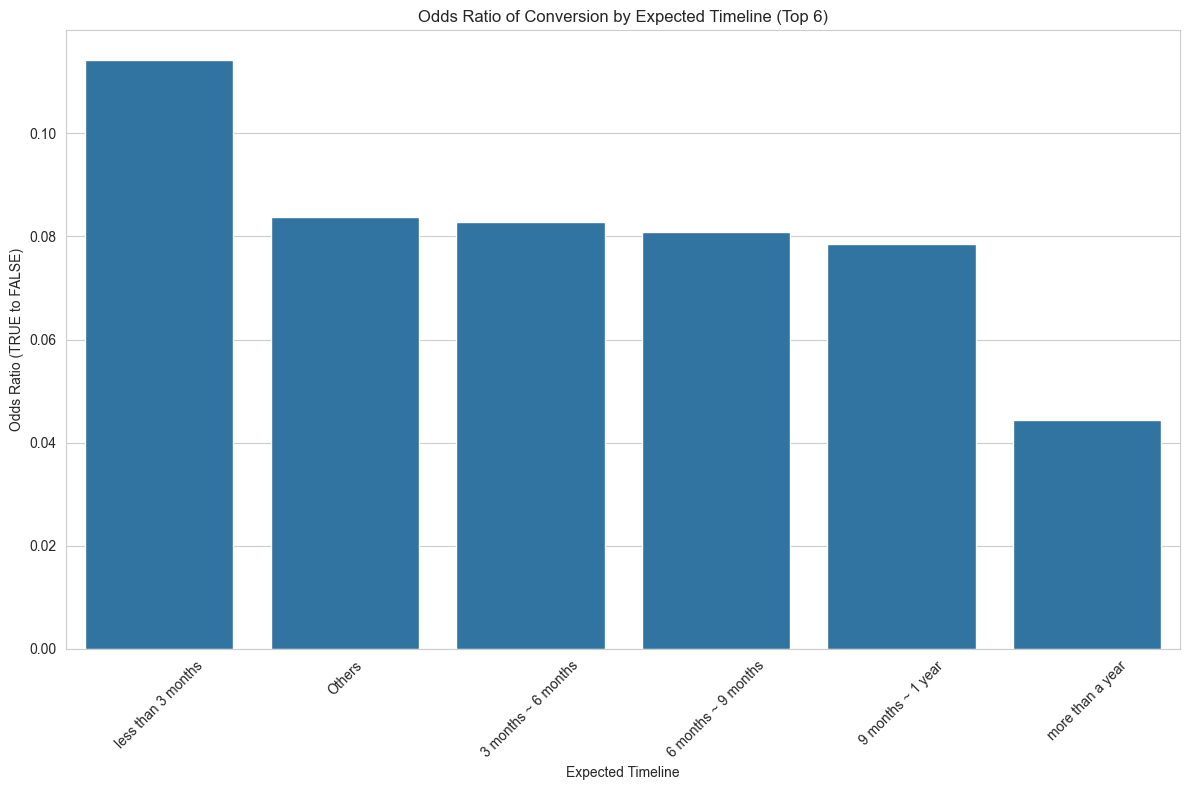

In [167]:
# Calculate the counts for each unique value in 'expected_timeline'
timeline_counts = df['expected_timeline'].value_counts()

# Identify the top 6 values
top_6_timelines = timeline_counts.nlargest(6).index.tolist()

# Filter the DataFrame to include only rows with the top 6 'expected_timeline' values
df_top_6_timelines = df[df['expected_timeline'].isin(top_6_timelines)]

# Create a contingency table for 'is_converted' within the filtered 'expected_timeline' values
conversion_counts_top_6 = df_top_6_timelines.groupby('expected_timeline')['is_converted'].value_counts().unstack(fill_value=0)

# Calculate odds ratio ('TRUE' to 'FALSE') for each 'expected_timeline'
conversion_counts_top_6['odds_ratio'] = conversion_counts_top_6['TRUE'] / conversion_counts_top_6.get('FALSE', 1)  # Avoid division by zero

# Reset index for plotting
conversion_counts_top_6.reset_index(inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=conversion_counts_top_6, x='expected_timeline', y='odds_ratio', order=conversion_counts_top_6.sort_values('odds_ratio', ascending=False)['expected_timeline'])
plt.xticks(rotation=45)
plt.xlabel('Expected Timeline')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Expected Timeline (Top 6)')
plt.tight_layout()
plt.show()

# decreasing trend of conversion found with time going higher
# ordinal data created. 

In [168]:
# running test chi-square test on expected_timeline
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['expected_timeline'], df['is_converted'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2}, p-value: {p}")

#Given the p-value is far below the common significance level (α) of 0.05 
#you can reject the null hypothesis and conclude that there is a 
#statistically significant association between the expected_timeline 
#and the conversion status (is_converted). 
#This means that the likelihood of conversion appears to be related to 
#the expected timeline categories you've defined in your dataset.

# 위는 significant 함.

Chi-square Statistic: 172.58806633450865, p-value: 1.2704971219859296e-34


### ver_win_rate_x vs. is_converted
#### numerical data, float type

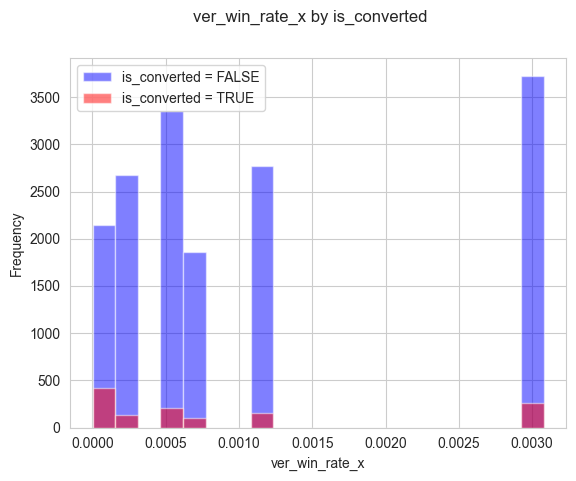

In [119]:
# ver_win_rate_x (68.1%)

fig, ax = plt.subplots()

ax.hist(df[df['is_converted'] == 'FALSE']['ver_win_rate_x'], bins=20, alpha=0.5, color='blue', label='is_converted = FALSE')
ax.hist(df[df['is_converted'] == 'TRUE']['ver_win_rate_x'], bins=20, alpha=0.5, color='red', label='is_converted = TRUE')

ax.set_xlabel('ver_win_rate_x')
ax.set_ylabel('Frequency')

fig.suptitle('ver_win_rate_x by is_converted')
ax.legend()

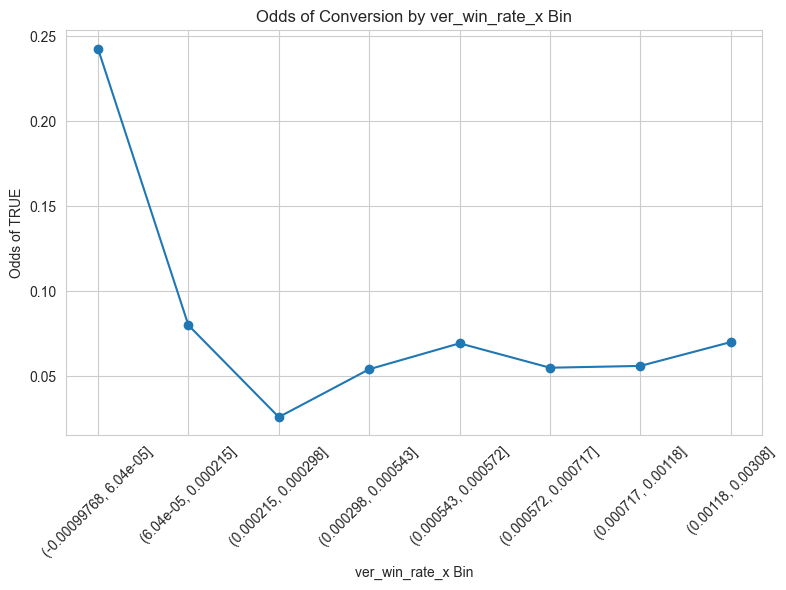

In [120]:
# odds ratio로 확인

df['ver_win_rate_x_bin'] = pd.qcut(df['ver_win_rate_x'].dropna(), q=10, duplicates='drop')

# Calculate the counts for TRUE and FALSE in each bin
counts = df.groupby(['ver_win_rate_x_bin', 'is_converted']).size().unstack(fill_value=0)

# Calculate the odds of being TRUE in each bin
counts['odds_true'] = counts['TRUE'] / counts['FALSE']

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(counts.index.astype(str), counts['odds_true'], marker='o', linestyle='-')
plt.xlabel('ver_win_rate_x Bin')
plt.ylabel('Odds of TRUE')
plt.title('Odds of Conversion by ver_win_rate_x Bin')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 상관관계 발견, wilcoxon test로 확인
# ver_win_rate_x 가 낮을 수록 odds 가 높음을 확인. 

In [41]:
# wilcoxon test

group_true = df[df['is_converted'] == 'TRUE']['ver_win_rate_x'].dropna()
group_false = df[df['is_converted'] == 'FALSE']['ver_win_rate_x'].dropna()

u_stat, p_value = mannwhitneyu(group_true, group_false)

print(f"U-statistic: {u_stat}, P-value: {p_value}")

# U-statistic: 양수, p-value 0.00001 이하 -> significant 증명

#significance가 있음을 확인

U-statistic: 8728712.0, P-value: 3.4331304190044304e-23


### ver_win_ratio_per_bu vs. is_converted
#### numerical data, float type

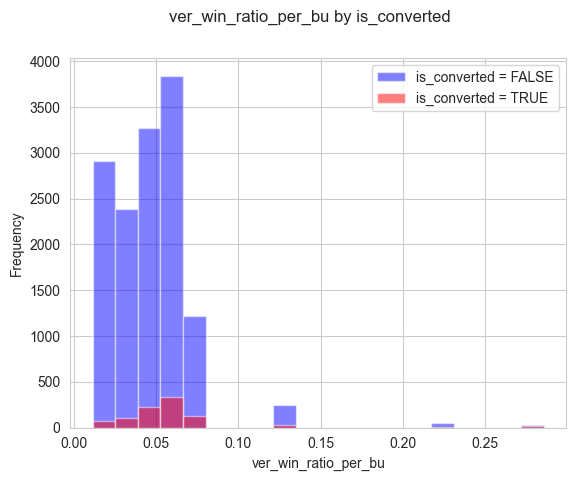

In [42]:
# ver_win_ratio_per_bu (73.3%)

fig, ax = plt.subplots()

ax.hist(df[df['is_converted'] == 'FALSE']['ver_win_ratio_per_bu'], bins=20, alpha=0.5, color='blue', label='is_converted = FALSE')
ax.hist(df[df['is_converted'] == 'TRUE']['ver_win_ratio_per_bu'], bins=20, alpha=0.5, color='red', label='is_converted = TRUE')

ax.set_xlabel('ver_win_ratio_per_bu')
ax.set_ylabel('Frequency')

fig.suptitle('ver_win_ratio_per_bu by is_converted')
ax.legend()

#ver_win_ratio_per_bu는 아래에서 보듯이 is_converted와 상당한 association을 보임
#ver_win_ratio_per_bu가 높을수록 is_converted가 TRUE일 확률이 높아보임

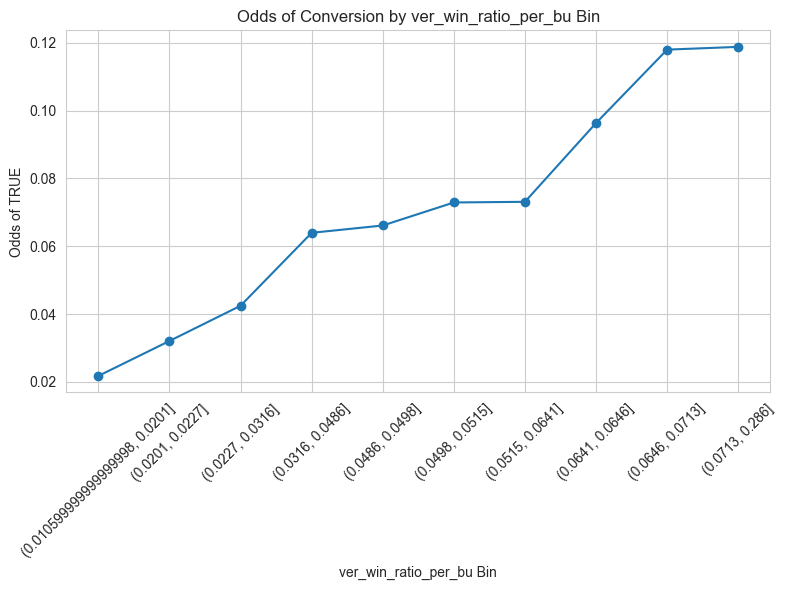

In [43]:
#odds ratio로 보면 더 분명할것같아서, 아래와 같이 10개 quantiles로 나누어서 plot 해보니 linear 한 상승값을 보인다. 

# Example: Binning 'ver_win_ratio_per_bu' into quantiles for simplicity
df['ver_win_ratio_per_bu_bin'] = pd.qcut(df['ver_win_ratio_per_bu'].dropna(), q=10, duplicates='drop')

# Calculate the counts for TRUE and FALSE in each bin
counts = df.groupby(['ver_win_ratio_per_bu_bin', 'is_converted']).size().unstack(fill_value=0)

# Calculate the odds of being TRUE in each bin
counts['odds_true'] = counts['TRUE'] / counts['FALSE']

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(counts.index.astype(str), counts['odds_true'], marker='o', linestyle='-')
plt.xlabel('ver_win_ratio_per_bu Bin')
plt.ylabel('Odds of TRUE')
plt.title('Odds of Conversion by ver_win_ratio_per_bu Bin')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
# 우리의 이런 가정을 증명하기 위해서, Wilcoxon test 진행

group_true = df[df['is_converted'] == 'TRUE']['ver_win_ratio_per_bu'].dropna()
group_false = df[df['is_converted'] == 'FALSE']['ver_win_ratio_per_bu'].dropna()

u_stat, p_value = mannwhitneyu(group_true, group_false)

print(f"U-statistic: {u_stat}, P-value: {p_value}")

# U-statistic: 양수, p-value 0.00001 이하 -> significant 증명

U-statistic: 8073815.5, P-value: 2.045638624818112e-39


### business_area vs. is_converted
#### categorical, nominal data

In [45]:
print(len(df.business_area.unique()))
df.business_area.value_counts()

13


business_area
corporate / office                3989
retail                            2924
hotel & accommodation             1959
special purpose                   1873
residential (home)                1786
education                         1682
hospital & health care            1023
factory                           1013
government department              635
public facility                    502
transportation                     292
power plant / renewable energy     108
Name: count, dtype: int64

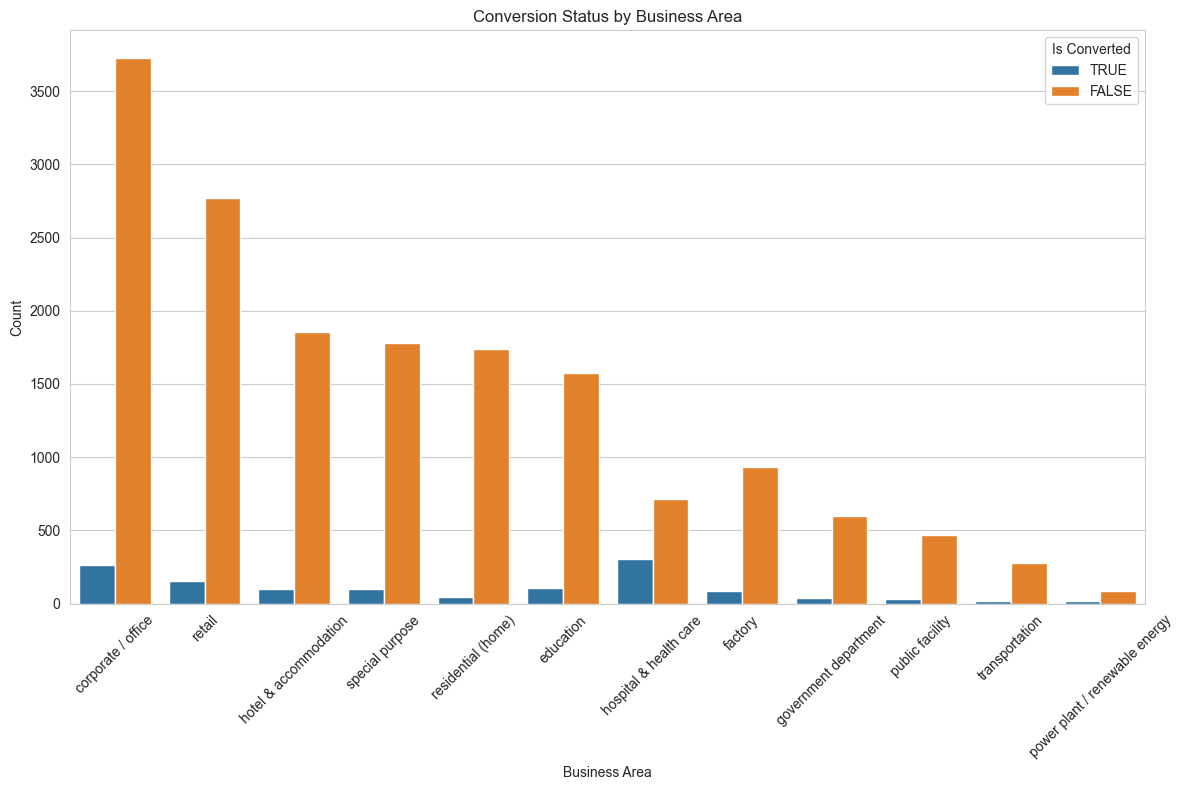

In [46]:
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.countplot(data=df, x='business_area', hue='is_converted', order=df['business_area'].value_counts().index)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('Business Area')
plt.ylabel('Count')
plt.title('Conversion Status by Business Area')
plt.legend(title='Is Converted')
plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

#이렇게만 보면 애매모호하니, odds ratio로 보자

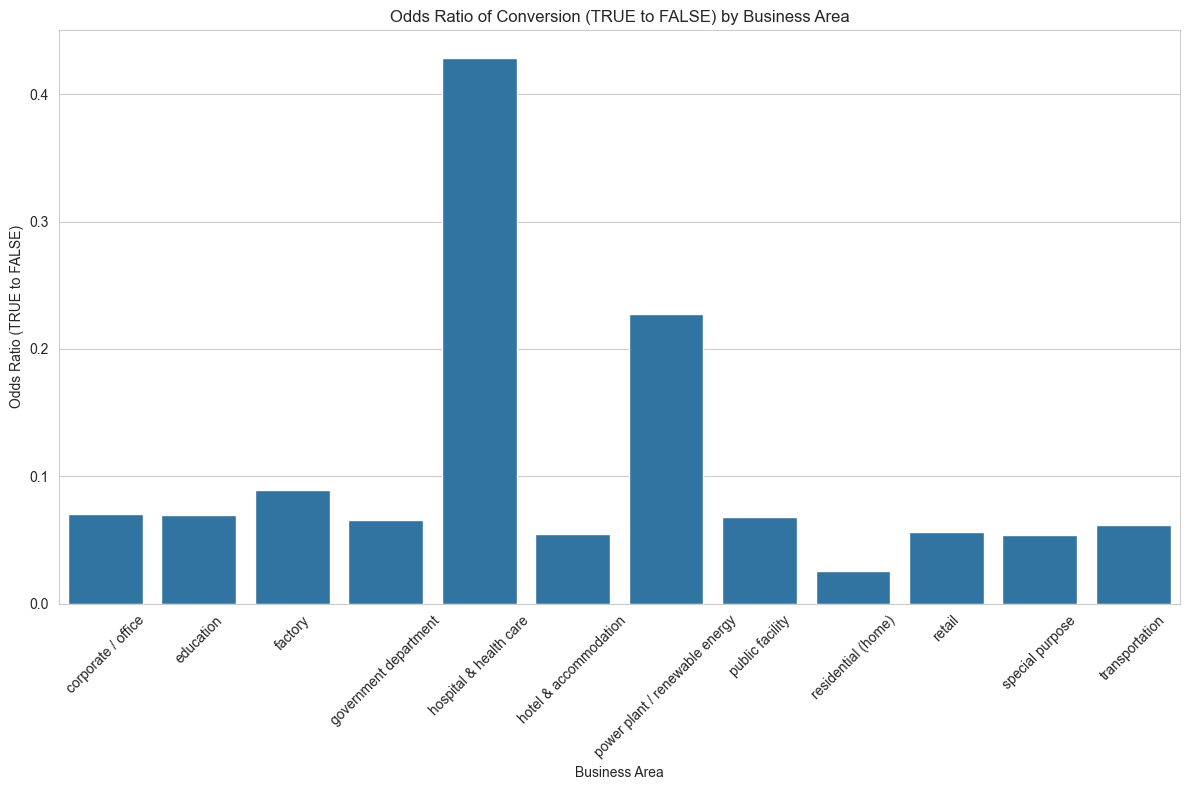

In [47]:
# odds ratio로 visualize 하였을때

# Calculate counts of 'is_converted' for each 'business_area'
conversion_counts = df.groupby('business_area')['is_converted'].value_counts().unstack(fill_value=0)

# Invert the odds ratio to 'TRUE' to 'FALSE'
conversion_counts['odds_ratio_true_to_false'] = conversion_counts['TRUE'] / conversion_counts['FALSE']

# Ensure there's no division by zero; handle cases where 'FALSE' count is 0
conversion_counts['odds_ratio_true_to_false'] = conversion_counts['odds_ratio_true_to_false'].replace([np.inf, -np.inf], np.nan)

# Reset index to make 'business_area' a column (for plotting)
conversion_counts.reset_index(inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=conversion_counts, x='business_area', y='odds_ratio_true_to_false')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('Business Area')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion (TRUE to FALSE) by Business Area')
plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

#아래는 TRUE-to-FALSE odds ratio 인데, 유독 hospital&health care 관련일때와, 
# power plant & renewable energy 일때 높은 odds ratio를 보인다.
# 이것은 business_area가 is_converted에 영향을 미친다는 것을 보여준다.

In [48]:
# significance 를 chi-square test로 확인
from scipy.stats import chi2_contingency

# Create a contingency table of observed counts
contingency_table = pd.crosstab(df['business_area'], df['is_converted'])

# Perform the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2}, P-value: {p}")

# chi-square 높은 양수값, p-value 0.05 이하 -> business_area vs. is_converted == significant 

Chi-square Statistic: 932.7697730435593, P-value: 5.57586535061509e-193


In [172]:
# import statsmodels.api as sm

# # Assuming 'is_converted' is already binary ('TRUE'/'FALSE'). Convert it to 0 and 1

# df['is_converted'] = df['is_converted'].map({'FALSE': 0, 'TRUE': 1}).astype(float)
# y = df['is_converted']

# # Get dummy variables for 'expected_timeline'
# timeline_dummies = pd.get_dummies(df['expected_timeline'], drop_first=True)  # Avoid multicollinearity

# # Prepare the independent variables (add constant for intercept)
# X = sm.add_constant(timeline_dummies)

# # Recheck and convert X to ensure it's fully numeric
# X = X.apply(pd.to_numeric, errors='coerce')

# # Adding a constant again to ensure it's correctly applied
# X = sm.add_constant(X, has_constant='add')

# # Drop NA values from y and X
# df_clean = df.dropna(subset=['is_converted'])
# X_clean = X.loc[df_clean.index]
# y_clean = y.loc[df_clean.index]

# # Check for any remaining non-numeric types in X
# print(X_clean.dtypes)

# X_clean = X_clean.astype(float)

# # This step may not be necessary if 'const' duplication was a misunderstanding, but ensure 'const' is present only once
# if 'const' in X_clean.columns:
#     X_clean = X_clean.loc[:,~X_clean.columns.duplicated()]


# # Fit the model|
# model = sm.Logit(y_clean, X_clean).fit()

# # Display the summary of the logistic regression model
# print(model.summary())

## 채우기 어려운 NA 19000개 칼럼들 분석

### customer_job vs. is_converted
#### categorical, nominal data

In [54]:
print(len(df.customer_job.unique()))
df.customer_job.value_counts()

561


customer_job
engineering                       6025
other                             4502
administrative                    3281
education                         2260
sales                             2138
                                  ... 
consultant,cabinet fabricator        1
appliance specialist                 1
av estimator                         1
purchasers                           1
exhibition / convention center       1
Name: count, Length: 560, dtype: int64

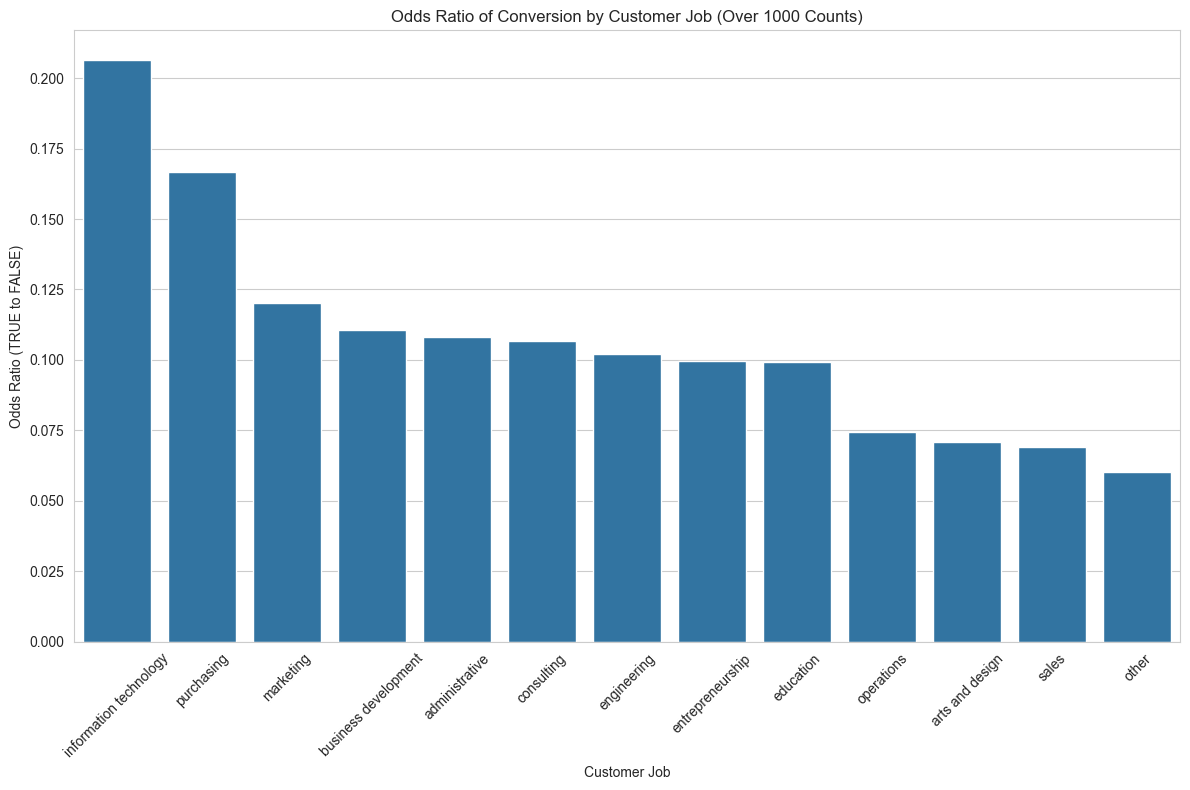

In [58]:
# Count the occurrences of each 'customer_job'
job_counts = df['customer_job'].value_counts()

# Filter to keep only those with more than 1000 counts
jobs_over_1000 = job_counts[job_counts > 1000].index

# Filter the DataFrame
df_filtered = df[df['customer_job'].isin(jobs_over_1000)]

# Create a contingency table for 'is_converted' within the filtered 'customer_job' categories
contingency = df_filtered.groupby('customer_job')['is_converted'].value_counts().unstack(fill_value=0)

# Calculate odds ratio ('TRUE' to 'FALSE') for each 'customer_job'
contingency['odds_ratio'] = contingency['TRUE'] / contingency['FALSE']

# Reset index for plotting
contingency.reset_index(inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=contingency, x='customer_job', y='odds_ratio', order=contingency.sort_values('odds_ratio', ascending=False)['customer_job'])
plt.xticks(rotation=45)
plt.xlabel('Customer Job')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Customer Job (Over 1000 Counts)')
plt.tight_layout()
plt.show()

#아래를 보면 확실히 IT계열과 purchasing이 높은 conversion ratio를 보이고 있다. 
# significance는 NA인 19000개 행의 conversion ratio와 비교하면 알것이다. 

0.0865123496702444


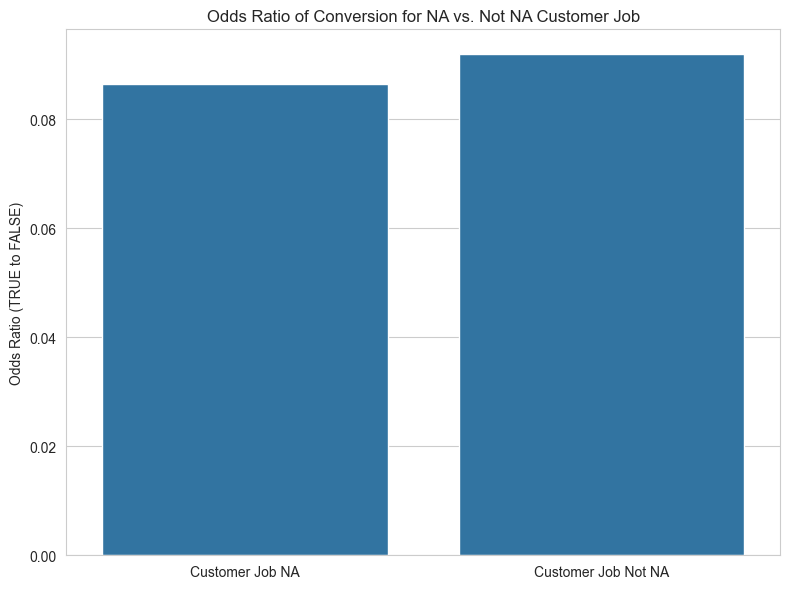

In [64]:
# Subset where 'customer_job' is NA
df_customer_job_na = df[df['customer_job'].isna()]

# Subset where 'customer_job' is not NA
df_customer_job_not_na = df[~df['customer_job'].isna()]

# Function to calculate odds ratio
def calculate_odds_ratio(df_subset):
    count_is_converted = df_subset['is_converted'].value_counts()
    odds_true = count_is_converted.get('TRUE', 0) / count_is_converted.get('FALSE', 1)  # Avoid division by zero
    return odds_true

# Calculate odds ratios
odds_ratio_na = calculate_odds_ratio(df_customer_job_na)
odds_ratio_not_na = calculate_odds_ratio(df_customer_job_not_na)

print(odds_ratio_na)
# Data for visualization
odds_ratios = {'Customer Job NA': odds_ratio_na, 'Customer Job Not NA': odds_ratio_not_na}
names = list(odds_ratios.keys())
values = list(odds_ratios.values())

# Create bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=names, y=values)
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion for NA vs. Not NA Customer Job')
plt.tight_layout()
plt.show()

# 전체적으로 보면, 자신의 직종을 나타내는것만으로는 conversion에 큰 영향을 미치지 않는것으로 보인다. 
# 그렇다면 각 category와 비교를 해보겠다.

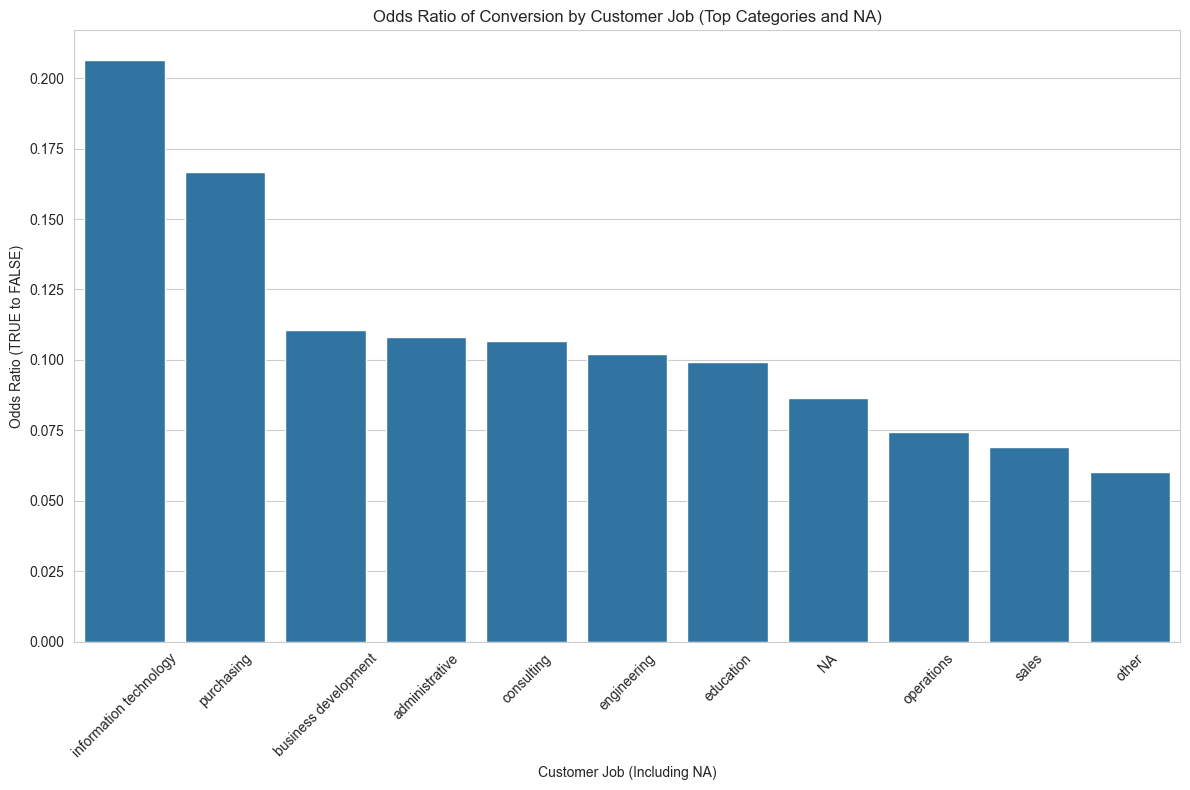

In [62]:
# Find the top 'customer_job' categories by count, excluding NAs
top_categories_counts = df['customer_job'].value_counts().nlargest(10)

# Include NA by creating a new category for visualization
df['customer_job_category'] = df['customer_job'].fillna('NA')

# Ensure the new "NA" category is included only if you want to compare it directly
df.loc[df['customer_job'].isna(), 'customer_job_category'] = 'NA'
top_categories_with_na = top_categories_counts.index.tolist() + ['NA']

df_filtered = df[df['customer_job_category'].isin(top_categories_with_na)]

# Calculate counts and odds ratios
conversion_counts = df_filtered.groupby('customer_job_category')['is_converted'].value_counts().unstack(fill_value=0)
conversion_counts['odds_ratio'] = conversion_counts['TRUE'] / conversion_counts.get('FALSE', 1)  # Avoid division by zero

# Reset index for plotting
conversion_counts.reset_index(inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=conversion_counts, x='customer_job_category', y='odds_ratio', order=conversion_counts.sort_values('odds_ratio', ascending=False)['customer_job_category'])
plt.xticks(rotation=45)
plt.xlabel('Customer Job (Including NA)')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Customer Job (Top Categories and NA)')
plt.tight_layout()
plt.show()

#아래에서 보듯, 카테고리별로는 IT와 purchasing이 NA보다 2.5/2배 더 높은 수치를 보이고, 이외 다른 직종들도
# NA보다는 조금 더 높은 odds ratio를 자랑하는듯 하다. 
# 이것을 활용하려면, NA값들은 그냥 Unknown이라는 새 카테고리로 정하는게 좋을듯하다. 
# 그래야지만 IT와 purchasing을 활용할 수 있을것이다. 


### product_category vs. is_converted
#### categorical, nominal data

In [66]:
print(len(df.product_category.unique()))
df.product_category.value_counts()

# 역시 300개가 넘어가는 value들이 있다. 
# 가장 significant한 category만 보기로 한다. 
# -> Pareto Analysis : 80% of effects come from 20% of the causes.

358


product_category
interactive digital board                     6090
vrf                                           5238
multi-split                                   3548
video wall signage                            2002
etc.                                          1954
                                              ... 
pc,tv                                            1
system ac                                        1
sac                                              1
gscd046                                          1
monior/monitor tv,refrigerator,audio/video       1
Name: count, Length: 357, dtype: int64

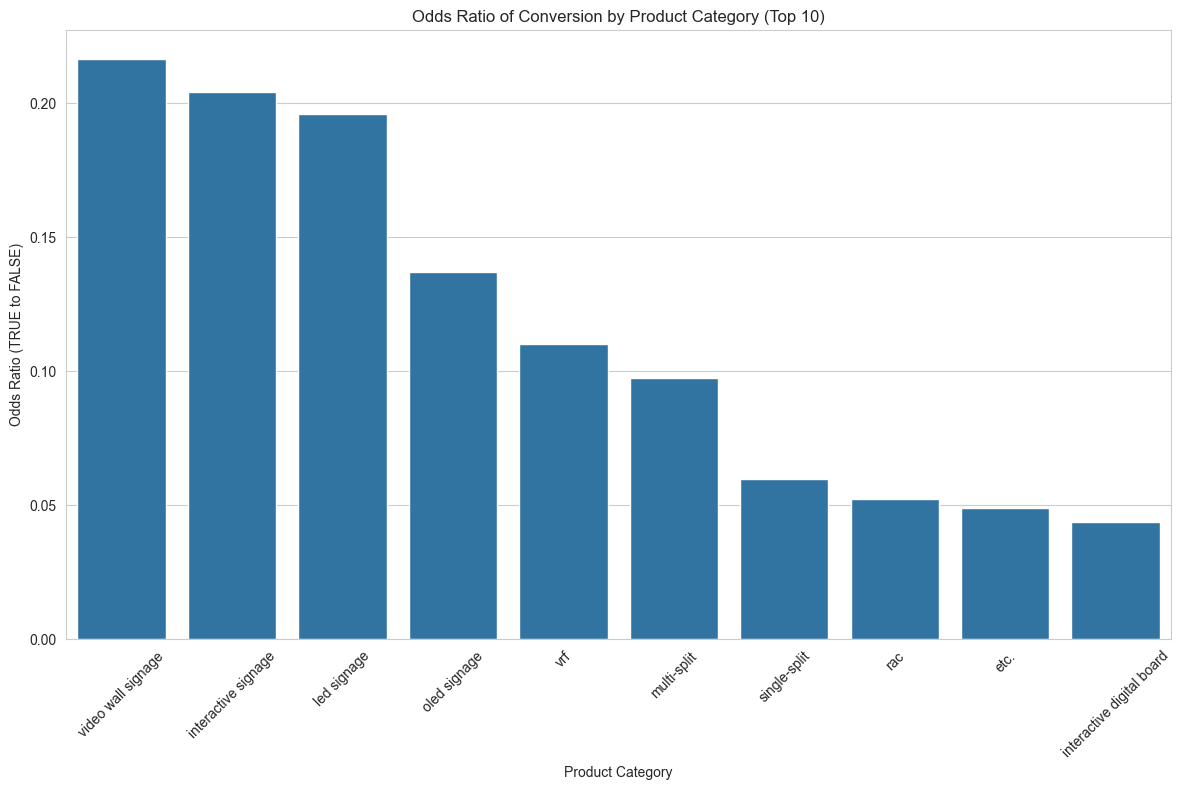

In [67]:
# Find the top 10 'product_category' categories by count
top_10_product_categories = df['product_category'].value_counts().nlargest(10).index

# Filter the DataFrame to keep only rows with the top 10 'product_category' values
df_top_10_product_categories = df[df['product_category'].isin(top_10_product_categories)]

# Calculate counts and odds ratios
conversion_counts_top_10 = df_top_10_product_categories.groupby('product_category')['is_converted'].value_counts().unstack(fill_value=0)
conversion_counts_top_10['odds_ratio'] = conversion_counts_top_10['TRUE'] / conversion_counts_top_10.get('FALSE', 1)  # Avoid division by zero

# Reset index for plotting
conversion_counts_top_10.reset_index(inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=conversion_counts_top_10, x='product_category', y='odds_ratio', order=conversion_counts_top_10.sort_values('odds_ratio', ascending=False)['product_category'])
plt.xticks(rotation=45)
plt.xlabel('Product Category')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Product Category (Top 10)')
plt.tight_layout()
plt.show()

# odds ratio of top 10 unique values 


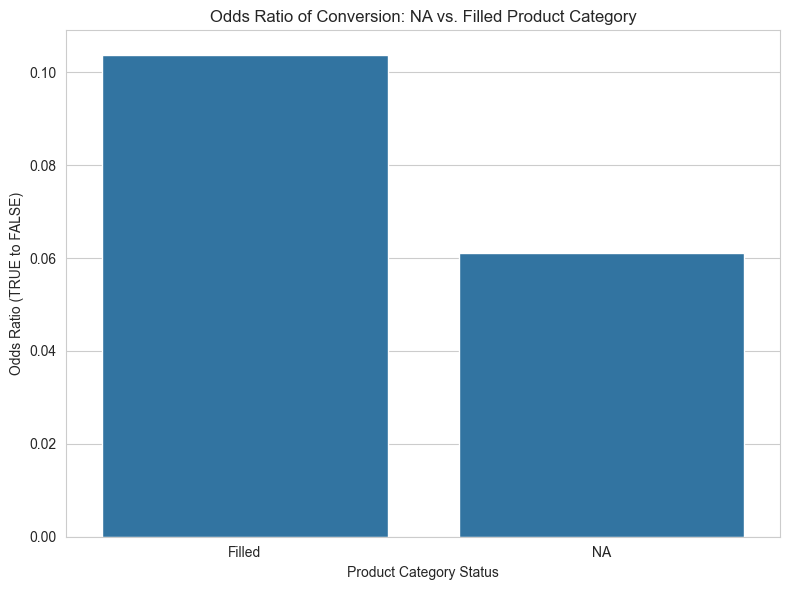

In [68]:
# Create a new column to differentiate between NA and non-NA 'product_category' values
df['product_category_status'] = np.where(df['product_category'].isna(), 'NA', 'Filled')

# Calculate counts and odds ratios for NA vs. Non-NA
conversion_counts_status = df.groupby('product_category_status')['is_converted'].value_counts().unstack(fill_value=0)
conversion_counts_status['odds_ratio'] = conversion_counts_status['TRUE'] / conversion_counts_status.get('FALSE', 1)

# Reset index for plotting
conversion_counts_status.reset_index(inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(data=conversion_counts_status, x='product_category_status', y='odds_ratio')
plt.xlabel('Product Category Status')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion: NA vs. Filled Product Category')
plt.tight_layout()
plt.show()


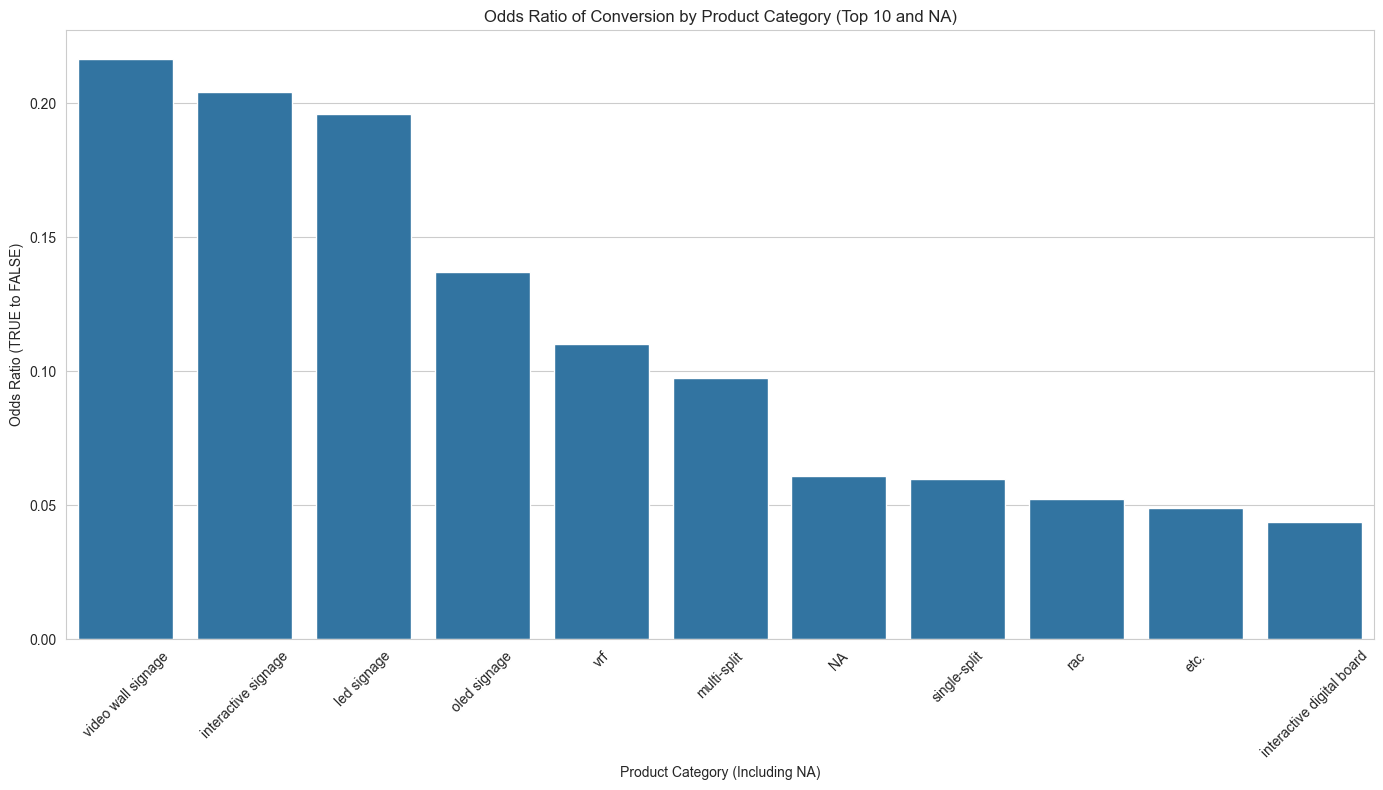

In [69]:
# Assuming the DataFrame df and necessary imports are already in place

# Identify top 10 categories including NA as a separate category
top_10_with_na = df['product_category'].value_counts().nlargest(10).index.tolist()
df['product_category_with_na'] = df['product_category'].fillna('NA')
top_10_including_na = top_10_with_na + ['NA'] if 'NA' not in top_10_with_na else top_10_with_na

# Filter df for relevant categories
df_relevant = df[df['product_category_with_na'].isin(top_10_including_na)]

# Calculate odds ratios
conversion_counts_incl_na = df_relevant.groupby('product_category_with_na')['is_converted'].value_counts().unstack(fill_value=0)
conversion_counts_incl_na['odds_ratio'] = conversion_counts_incl_na['TRUE'] / conversion_counts_incl_na.get('FALSE', 1)  # Avoid division by zero

# Reset index for plotting
conversion_counts_incl_na.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
sns.barplot(data=conversion_counts_incl_na, x='product_category_with_na', y='odds_ratio', order=conversion_counts_incl_na.sort_values('odds_ratio', ascending=False)['product_category_with_na'])
plt.xticks(rotation=45)
plt.xlabel('Product Category (Including NA)')
plt.ylabel('Odds Ratio (TRUE to FALSE)')
plt.title('Odds Ratio of Conversion by Product Category (Top 10 and NA)')
plt.tight_layout()
plt.show()

# NA value added as comparison. I think similar approach like that of 'customer_job' will be taken here. 